# Assignment 6 - Object recognition in images with deep learning

## Goals

In this assignment you will get to know the main ingredients of deep learning and get to use the GPUs available in the Big Data Lab.

You'll learn to use

 * tensors and automatic differentiation
 * layered models
 * p(re)trained networks for image classification.

## Check the GPU setup

When you are logged in to a lab machine, run ``nvidia-smi`` to see the available card and its memory usage.

```
$ nvidia-smi
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.102.04   Driver Version: 450.102.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 105...  Off  | 00000000:01:00.0  On |                  N/A |
| 45%   24C    P8    N/A /  75W |   3087MiB /  4038MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU       PID   Type   Process name                             Usage      |
|=============================================================================|
|    0      3627      G   /usr/lib/xorg/Xorg                           169MiB |
|    0     10843      C   ...d/CMPT/big-data/tmp_py/dlenv/bin/python  2897MiB |
+-----------------------------------------------------------------------------+
```

This shows that the machine has an **NVIDIA GTX 1050 with 4G of RAM**. Also, you can see that it is running a process (pid=10843) that currently takes up close to 3 GB of GPU memory. On our current `blu9402` lab machines you will notice a difference, as they have 8GB of RAM.

```
$ pstree -ls 10843
screen───bash───jupyter-noteboo───python─┬─4*[python]
                                         └─26*[{python}]
```
Inside a terminal window you may use ``who``, ``ps -aux | less``, or ``pstree -ls <PID>`` as above to find out who is using the shared resources. In my case, it turns out that I'm running a jupyter notebook related to process 10843. Halting the notebook frees up the GPU memory. 

## PyTorch setup in the lab

To build deep learning models in this assignment we are using **[PyTorch](http://pytorch.org)**, a replacement for numpy that provides accelerated computation on the GPU, automatic differentiation, and various utilities to train and deploy neural networks. Its popularity relative to [tensorflow](http://tensorflow.org) has been steadily increasing and it also has a high-level API, the [NN module](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) similar to [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras).

In case you have trouble configuring a conda environment that has a CUDA version of pytorch installed, you could use the one that's provided under the prefix  
`conda activate /usr/shared/CMPT/big-data/condaenv/gt`

### Save disk space in the lab: Use shared downloaded pre-built models
To save disk space in your home folder, we recommend that you let pytorch use the pre-built models that we already downloaded for you (about 1.9G):
```
mkdir -p ~/.cache/torch/hub/checkpoints
ln -s /usr/shared/CMPT/big-data/dot_torch_shared/checkpoints/* ~/.cache/torch/hub/checkpoints
```

## Learn about Pytorch usage

To familiarize yourself with PyTorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html) on Tensors, or the NN module, or briefly skim over the [60 min blitz tutorial](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

# Task 1: Finding rectangles

A nice [**blog-post** by Johannes Rieke](https://towardsdatascience.com/object-detection-with-neural-networks-a4e2c46b4491) presents a simple setup from scratch that finds rectangles in a black & white image. In order to play with it, we just have to translate a few calls from Keras to PyTorch.

To familiarize yourself with using pytorch, have a look at the [Examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html). The following code is preparing our training setup.

In [69]:
# to check GPU memory, uncomment and run the following line
# !{'nvidia-smi'}

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [39]:
torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

device(type='cuda', index=0)

The training data consists of $50,000$ example images.  
`imgs` is an array of shape (50000, 8, 8), giving an $8\times8$ pixel image for each example.  
`bboxes` is an array of shape (50000, 1, 4), giving a $1\times4$ row vector [x, y, w, h] for each rectangle.

**Here is an example of the training data:**

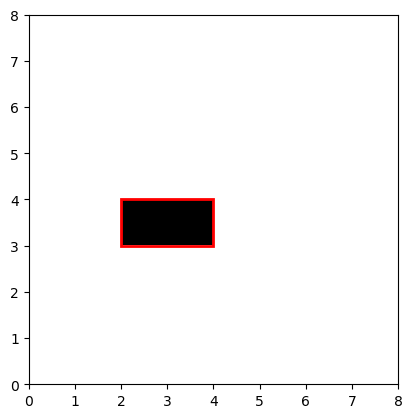

In [40]:
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib

# Create images with random rectangles and bounding boxes. 
num_imgs = 50000

img_size = 8
min_object_size = 1
max_object_size = 4
num_objects = 1

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))  # set background to 0

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_object_size, max_object_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.  # set rectangle to 1
        bboxes[i_img, i_object] = [x, y, w, h]

display(Markdown(f"The training data consists of ${num_imgs:,}$ example images.  \n"
                 f"`imgs` is an array of shape {imgs.shape}, giving an ${img_size}\\times{img_size}$ pixel image for each example.  \n"
                 f"`bboxes` is an array of shape {bboxes.shape}, giving a $1\\times4$ row vector [x, y, w, h] for each rectangle."
                ))
display(Markdown('**Here is an example of the training data:**'))
i = 0
plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
for bbox in bboxes[i]:
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none', lw=2))

In [41]:
# Reshape and normalize the image data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
display(Markdown(f"New shape of `imgs`: {X.shape}, with normalized mean {np.mean(X):.2f} and stdev {np.std(X):.2f}"))

# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

# Split training and test.
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

New shape of `imgs`: (50000, 64), with normalized mean 0.00 and stdev 1.00

## Task 1a
**Construct a Pytorch model that resembles the Keras one in the original blog post**, i.e. have a fully connected, hidden layer with 200 neurons, ReLU nonlinearity and dropout rate of 20%.

In [42]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dropout = nn.Dropout(0.2)

        self.conv1 = nn.Conv2d(1, 6, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        
        self.fc1 = nn.Linear(16, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 4)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], 1, 8, 8))
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = Net()

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0625, betas=(0.9, 0.9))
loss_fn = torch.nn.SmoothL1Loss(size_average=False)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [44]:
inputs = Variable(torch.Tensor(train_X))
labels = Variable(torch.Tensor(train_y))

In [45]:
phase = 'train'

model.train()
do_test_loss = False

loss_record = []
loss_test_record = []
for epoch in range(6000):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    print(epoch, loss)
    loss_record.append(loss.data.item())

    if phase == 'train':
        loss.backward()
        optimizer.step()
    
    if do_test_loss:
        outputs_test = model(inputs_test)
        loss_test = loss_fn(outputs_test, labels_test)
        loss_test_record.appentrain_modeld(loss_test.data.item())
    

0 tensor(13173.6152, grad_fn=<SmoothL1LossBackward0>)
1 tensor(13088.1953, grad_fn=<SmoothL1LossBackward0>)
2 tensor(13003.2539, grad_fn=<SmoothL1LossBackward0>)
3 tensor(12918.6738, grad_fn=<SmoothL1LossBackward0>)
4 tensor(12834.4248, grad_fn=<SmoothL1LossBackward0>)
5 tensor(12750.2871, grad_fn=<SmoothL1LossBackward0>)
6 tensor(12666.5332, grad_fn=<SmoothL1LossBackward0>)
7 tensor(12583.0469, grad_fn=<SmoothL1LossBackward0>)
8 tensor(12499.9775, grad_fn=<SmoothL1LossBackward0>)
9 tensor(12417.2666, grad_fn=<SmoothL1LossBackward0>)
10 tensor(12334.9541, grad_fn=<SmoothL1LossBackward0>)
11 tensor(12253.0508, grad_fn=<SmoothL1LossBackward0>)
12 tensor(12171.6953, grad_fn=<SmoothL1LossBackward0>)
13 tensor(12090.6328, grad_fn=<SmoothL1LossBackward0>)
14 tensor(12009.9473, grad_fn=<SmoothL1LossBackward0>)
15 tensor(11929.4453, grad_fn=<SmoothL1LossBackward0>)
16 tensor(11849.3076, grad_fn=<SmoothL1LossBackward0>)
17 tensor(11769.6445, grad_fn=<SmoothL1LossBackward0>)
18 tensor(11690.2246

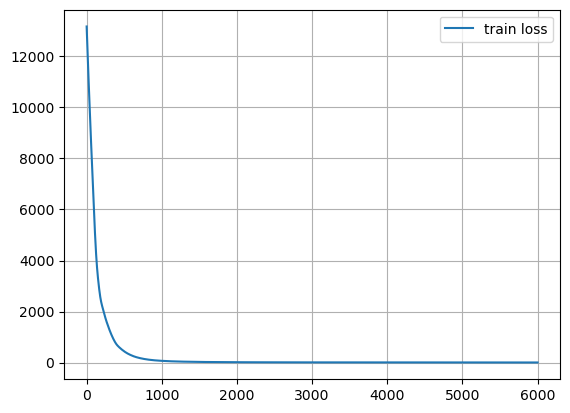

In [46]:
plt.plot(loss_record)
if do_test_loss:
    plt.plot(loss_test_record)
    plt.legend(["train loss", "test loss"])
else:
    plt.legend(["train loss"])
plt.grid(True)

**Change the model from training to evaluation mode** to improve testing performance.

In [47]:
phase = 'test'

# TODO
model.eval()
inputs_test = Variable(torch.Tensor(test_X))
labels_test = Variable(torch.Tensor(test_y))

loss_record = []
with torch.no_grad():
    outputs_test = model(inputs_test)
    loss_test = loss_fn(outputs_test, labels_test)
    loss_test_record.append(loss_test.data.item())

In [48]:
# Predict bounding boxes on the test images.
pred_y = model(Variable(torch.Tensor(test_X)))
pred_bboxes = pred_y.data * img_size
pred_bboxes = pred_bboxes.numpy().reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 1, 4)

In [50]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0.
    I = w_I * h_I
    U = w1 * h1 + w2 * h2 - I
    return I / U

0.964175180281605

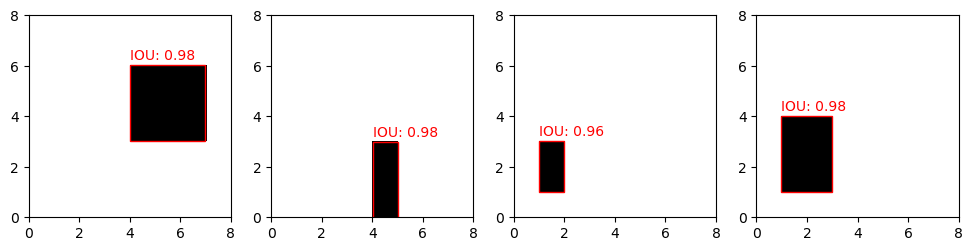

In [51]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_imgs))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))
        plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
# Calculate the mean IOU (overlap) between the predicted and expected bounding boxes on the test dataset. 
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

## Task 1b:
Move the computation that is currently done on the CPU over to the GPU using CUDA and increase the number of epochs.  **Improve the training setup**, possibly also changing model or optimizer, until you **reach a test IOU above 0.9**.

You can make the changes that move computation to the GPU directly in the cells above as part of 1a.

You may get stuck not achieving test IOU above 0.6. In that case, learn about switching the model to evaluation mode and apply the change above.

## Question 1c:
Why does `eval` mode above have such a significant effect on test performance? Please give a short answer below.


When the model is set to training mode, the operations like dropout and others which introduce randomness to the model is used, this bascially prevents the model from overfitting. But during the evaluation mode, we do not need the randomness as it may lead to different output everytime we test with the same input. Therefore these elements which introduce randomness are disabled. Because of this the testing with and without eval will show a significant difference.

# Task 2: Use a pretrained model

As mentioned in class, deep learning systems are hardly ever developed from scratch, but usually work by refining existing solutions to similar problems. For the following task, we'll **work through the 
[Transfer learning tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)**, which also provides a ready-made jupyter notebook.

 **2.1.** Download the notebook and get it to run in your environment. This also involves downloading the bees and ants dataset.  
 **2.2.** Perform your own training with the provided setup, fill out the answer to Task 2.2 below.  
 **2.3.** Change the currently chosen pretrained network (resnet) to a different one. At least try out VGG and one other type and use the "conv net as fixed feature extractor" approach, fill out the answer to Task 2.3 below.  
 **2.4.** Load a picture that you took yourself and classify it with an unmodified pretrained network (e.g. the original VGG network) that can detect one out of 1000 classes. Fill out the answer to Task 2.4 below.

## Your solution for Task 2

Before you start, get the data from [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip) and extract it into a subfolder `data`. The following import is going to attempt loading the image data from there.

Initialize much of the source code from the tutorial notebook located at
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
using [this module](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/tfl_tut.py)

In [15]:
from tfl_tut import *

Please study the original notebook and then continue to use its functions as imported from the `tfl_tut` model for convenience to minimize source code copy & paste.

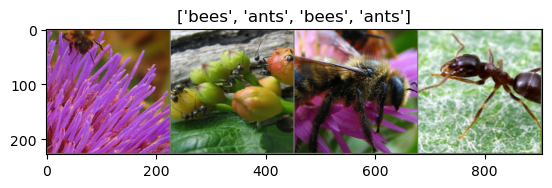

In [17]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
model_conv = models.inception_v3(pretrained=True)

### Answer for Task 2.2

In [10]:
# TODO paste and maybe modify relevant code to perform your own training

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

# torch.save(model_ft, './model_ft.pth')

Epoch 0/24
----------
train Loss: 0.5471 Acc: 0.7336
val Loss: 0.2886 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.5143 Acc: 0.7992
val Loss: 0.2347 Acc: 0.9216

Epoch 2/24
----------
train Loss: 0.4942 Acc: 0.7746
val Loss: 0.8867 Acc: 0.6471

Epoch 3/24
----------
train Loss: 0.4852 Acc: 0.8197
val Loss: 0.2248 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.4295 Acc: 0.8279
val Loss: 0.2335 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.6377 Acc: 0.7787
val Loss: 0.3062 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.4760 Acc: 0.8074
val Loss: 0.7959 Acc: 0.7451

Epoch 7/24
----------
train Loss: 0.4827 Acc: 0.7705
val Loss: 0.2594 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.3091 Acc: 0.8648
val Loss: 0.2271 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.2745 Acc: 0.8730
val Loss: 0.2175 Acc: 0.9216

Epoch 10/24
----------
train Loss: 0.3154 Acc: 0.8525
val Loss: 0.2121 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3442 Acc: 0.8566
val Loss: 0.2001 Acc: 0.9477

Ep

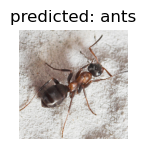

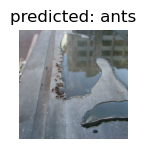

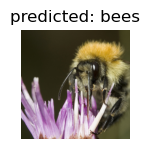

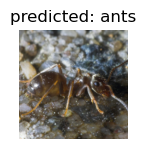

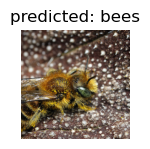

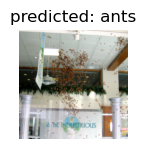

In [26]:
# model_conv = torch.load('model_ft.pth')
visualize_model(model_ft)

### Answer for Task 2.3

### Hints for this task

Focus on the section **Conv net as fixed feature xtractor** of the transfer learning tutorial.
First, change the line
```
model_conv = models.resnet18(pretrained=True)
```
to load VGG16 instead. Set all its parameters to *not* require gradient computation, as shown in the tutorial.

Next, print out the new `model_conv` and identify the last step of the classification. This is not named the same way as the ```fc``` layer for resnet, but it works similarily. The last classification step of the VGG model determines the probabilities for each of the 1000 classes of the dataset. Change this layer to identify only 2 classes to distinguish ants and bees as in the example.

To change the structure of some `Sequential` component called ```model_conv.module_name``` and to modify its last layer into a `DifferentLayer` type, you can use this syntax:

```
nn.Sequential(*list(model_conv.module_name.children())[:-1] +
                     [nn.DifferentLayer(...)])
```
and replace the old `model_conv.module_name` with this differently structured version.

In [12]:
# TODO

model_conv = torchvision.models.vgg16(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

in_feature = model_conv.classifier[-1].in_features

binary_classifer = nn.Sequential(*list(model_conv.classifier.children())[:-1] +
                     [nn.Linear(in_features=in_feature, out_features=2, bias=True)])

model_conv.classifier = binary_classifer

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

# torch.save(model_conv, 'model_conv.pth')

Epoch 0/24
----------
train Loss: 0.3530 Acc: 0.8770
val Loss: 0.1078 Acc: 0.9608

Epoch 1/24
----------
train Loss: 0.1617 Acc: 0.9303
val Loss: 0.1311 Acc: 0.9477

Epoch 2/24
----------
train Loss: 0.1751 Acc: 0.9385
val Loss: 0.1403 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.1648 Acc: 0.9385
val Loss: 0.1259 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.1994 Acc: 0.9262
val Loss: 0.1684 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.1133 Acc: 0.9549
val Loss: 0.0721 Acc: 0.9739

Epoch 6/24
----------
train Loss: 0.1711 Acc: 0.9467
val Loss: 0.0820 Acc: 0.9739

Epoch 7/24
----------
train Loss: 0.1470 Acc: 0.9508
val Loss: 0.0797 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.0766 Acc: 0.9713
val Loss: 0.0780 Acc: 0.9673

Epoch 9/24
----------
train Loss: 0.1359 Acc: 0.9426
val Loss: 0.0766 Acc: 0.9608

Epoch 10/24
----------
train Loss: 0.2232 Acc: 0.9426
val Loss: 0.0764 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.1509 Acc: 0.9385
val Loss: 0.0796 Acc: 0.9542

Ep

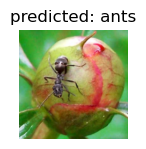

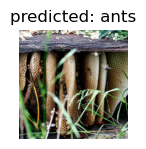

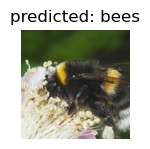

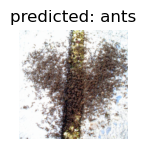

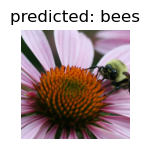

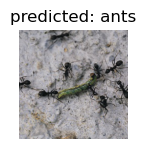

In [18]:
# model_conv = torch.load('model_conv.pth')
visualize_model(model_conv)

### Answer for Task 2.4

In [19]:
! wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
! wget https://www.wwf.org.uk/sites/default/files/styles/gallery_image/public/2020-05/Small_WW255506.jpg -O bee.jpg

--2023-02-22 20:47:27--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.006s  

2023-02-22 20:47:27 (1.78 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



Exception ignored in: <function _releaseLock at 0x7f1403ddfa60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/logging/__init__.py", line 223, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


--2023-02-22 20:47:27--  https://www.wwf.org.uk/sites/default/files/styles/gallery_image/public/2020-05/Small_WW255506.jpg
Resolving www.wwf.org.uk (www.wwf.org.uk)... 192.124.249.22
Connecting to www.wwf.org.uk (www.wwf.org.uk)|192.124.249.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 120561 (118K) [image/jpeg]
Saving to: ‘bee.jpg’

bee.jpg             100%[===================>] 117.74K  --.-KB/s    in 0.08s   

2023-02-22 20:47:27 (1.41 MB/s) - ‘bee.jpg’ saved [120561/120561]



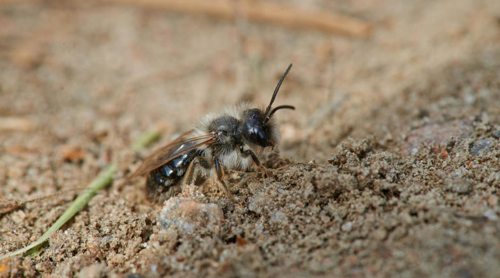

In [18]:
from PIL import Image

image = Image.open("bee.jpg")
image.thumbnail((500, 500))
image


In [19]:
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

In [21]:
# TODO
model_conv_orig = torchvision.models.vgg16(pretrained=True)

model_conv_orig.to(device)

image_tensor = data_transforms['val'](image).to(device)

image_input = image_tensor.unsqueeze(0).float()

model_conv_orig.eval()
with torch.no_grad():
    outputs = model_conv_orig(image_input)
    _, preds = torch.max(outputs, 1)
    print(categories[preds])

bee


Please include the picture so we can view it and its class label in the saved notebook. It's OK, if we don't have the actual image file to reproduce the output.

## Submission

Your submission should be based on a modified version of [this notebook](https://github.com/sfu-db/bigdata-cmpt733/blob/master/Assignments/A6/A6.ipynb) containing answers to Task 1 and for Task 2, saved with figures including some portions of the transfer learning tutorial notebook in the sections for tasks 2.1 - 2.4.